 Imports and Seeding

In [12]:
import os
import random
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# For reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

Device and Hyperparameters

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 20
NUM_EPOCHS = 30  # Reduced epochs since we're training a combined model
LEARNING_RATE = 0.0001
IMAGE_SIZE = 128
NUM_CLASSES = 14  # HG14 has 14 classes
DROPOUT_RATE = 0.5

Using device: cuda


Paths and Transforms

In [14]:
# Data paths - Replace with your actual paths
DATA_PATH = "/kaggle/input/hg14-split/HG14_split"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "test")

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Datasets and Loaders

In [15]:
# Load datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = ImageFolder(root=VAL_PATH, transform=val_test_transform)
test_dataset = ImageFolder(root=TEST_PATH, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset info
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {train_dataset.classes}")

Training set size: 9800
Validation set size: 2800
Test set size: 1400
Number of classes: 14
Class names: ['Gesture_0', 'Gesture_1', 'Gesture_10', 'Gesture_11', 'Gesture_12', 'Gesture_13', 'Gesture_2', 'Gesture_3', 'Gesture_4', 'Gesture_5', 'Gesture_6', 'Gesture_7', 'Gesture_8', 'Gesture_9']


Model Definition

In [16]:
class DirichletEnsembleModel(nn.Module):
    """
    A combined model using all four pre-trained networks with learnable weights
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(DirichletEnsembleModel, self).__init__()
        
        # Initialize the four base models
        self.vgg16 = self._get_vgg16(num_classes)
        self.vgg19 = self._get_vgg19(num_classes)
        self.mobilenet = self._get_mobilenet(num_classes)
        self.mobilenet_v2 = self._get_mobilenet_v2(num_classes)
        
        # Initialize ensemble weights as learnable parameters
        # Start with equal weights (will be normalized in forward pass)
        self.ensemble_weights = nn.Parameter(torch.ones(4) / 4)
        
    def _get_vgg16(self, num_classes):
        model = models.vgg16(pretrained=True)
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        return model
    
    def _get_vgg19(self, num_classes):
        model = models.vgg19(pretrained=True)
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        return model
    
    def _get_mobilenet(self, num_classes):
        model = models.mobilenet_v2(pretrained=True)
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        return model
    
    def _get_mobilenet_v2(self, num_classes):
        model = models.mobilenet_v2(pretrained=True)
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        return model
    
    def forward(self, x):
        # Get logits from each model
        vgg16_out = self.vgg16(x)
        vgg19_out = self.vgg19(x)
        mobilenet_out = self.mobilenet(x)
        mobilenet_v2_out = self.mobilenet_v2(x)
        
        # Convert logits to probabilities
        vgg16_probs = torch.softmax(vgg16_out, dim=1)
        vgg19_probs = torch.softmax(vgg19_out, dim=1)
        mobilenet_probs = torch.softmax(mobilenet_out, dim=1)
        mobilenet_v2_probs = torch.softmax(mobilenet_v2_out, dim=1)
        
        # Normalize ensemble weights using softmax to ensure they sum to 1
        weights = torch.softmax(self.ensemble_weights, dim=0)
        
        # Weighted ensemble (Dirichlet ensemble)
        ensemble_out = (
            weights[0] * vgg16_probs + 
            weights[1] * vgg19_probs + 
            weights[2] * mobilenet_probs + 
            weights[3] * mobilenet_v2_probs
        )
        
        # Convert back to logits for loss calculation (optional)
        # You could also directly return ensemble_out if using a different loss function
        ensemble_logits = torch.log(ensemble_out + 1e-8)  # Add small epsilon to avoid log(0)
        
        return ensemble_logits

Training Function

In [17]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    """
    Train the ensemble model
    """
    best_val_acc = 0.0
    best_model_weights = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        # Print current ensemble weights
        weights = torch.softmax(model.ensemble_weights, dim=0).detach().cpu().numpy()
        print(f"Ensemble weights: VGG16: {weights[0]:.4f}, VGG19: {weights[1]:.4f}, MobileNet: {weights[2]:.4f}, MobileNetV2: {weights[3]:.4f}")
        
        # Adjust learning rate
        scheduler.step(val_epoch_loss)
        
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_weights = model.state_dict().copy()
            torch.save(model.state_dict(), "ensemble_best.pth")
    
    print(f'Best val accuracy: {best_val_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history


Evaluation and Utility Functions

In [18]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    """
    Evaluate model performance on test data
    """
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    return test_loss, test_acc, all_preds, all_labels

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    """
    Create and plot a confusion matrix visualization
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# Plot training and validation curves
def plot_learning_curves(history):
    """
    Plot training and validation loss and accuracy curves
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("ensemble_learning_curves.png")
    plt.show()

# Function to use the trained ensemble for prediction
def predict_gesture(model, image_path):
    """
    Use the trained ensemble model to predict hand gesture from an image
    
    Args:
        model: Trained ensemble model
        image_path: Path to the image file
        
    Returns:
        Predicted class index and class name
    """
    # Load image
    transform = val_test_transform
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_class = torch.argmax(output, dim=1).item()
    
    # Get class name
    class_names = train_dataset.classes
    pred_class_name = class_names[pred_class]
    
    return pred_class, pred_class_name

def save_predictions_to_file(preds, labels, class_names, filename="predictions.csv"):
    """
    Save predictions and corresponding true labels to a CSV file.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Index", "True Label", "True Class", "Predicted Label", "Predicted Class"])
        for i, (true, pred) in enumerate(zip(labels, preds)):
            writer.writerow([i, true, class_names[true], pred, class_names[pred]])
    print(f"Predictions saved to {filename}")

Main

Training ensemble model from scratch...
Epoch 1/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.26it/s]


Ensemble weights: VGG16: 0.2645, VGG19: 0.2645, MobileNet: 0.2353, MobileNetV2: 0.2357
Train Loss: 1.2095, Train Acc: 0.7368
Val Loss: 0.6496, Val Acc: 0.9525
Epoch 2/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.34it/s]


Ensemble weights: VGG16: 0.2766, VGG19: 0.2760, MobileNet: 0.2238, MobileNetV2: 0.2236
Train Loss: 0.5675, Train Acc: 0.9683
Val Loss: 0.4462, Val Acc: 0.9893
Epoch 3/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.2863, VGG19: 0.2853, MobileNet: 0.2137, MobileNetV2: 0.2147
Train Loss: 0.4033, Train Acc: 0.9865
Val Loss: 0.2903, Val Acc: 0.9943
Epoch 4/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.2932, VGG19: 0.2917, MobileNet: 0.2060, MobileNetV2: 0.2092
Train Loss: 0.2469, Train Acc: 0.9926
Val Loss: 0.1344, Val Acc: 0.9968
Epoch 5/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.25it/s]


Ensemble weights: VGG16: 0.2975, VGG19: 0.2960, MobileNet: 0.2005, MobileNetV2: 0.2061
Train Loss: 0.1416, Train Acc: 0.9947
Val Loss: 0.0764, Val Acc: 0.9950
Epoch 6/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.3007, VGG19: 0.2989, MobileNet: 0.1963, MobileNetV2: 0.2040
Train Loss: 0.0835, Train Acc: 0.9963
Val Loss: 0.0405, Val Acc: 0.9946
Epoch 7/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.3030, VGG19: 0.3010, MobileNet: 0.1938, MobileNetV2: 0.2022
Train Loss: 0.0553, Train Acc: 0.9959
Val Loss: 0.0220, Val Acc: 0.9957
Epoch 8/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.32it/s]


Ensemble weights: VGG16: 0.3051, VGG19: 0.3029, MobileNet: 0.1917, MobileNetV2: 0.2003
Train Loss: 0.0389, Train Acc: 0.9978
Val Loss: 0.0195, Val Acc: 0.9961
Epoch 9/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.30it/s]


Ensemble weights: VGG16: 0.3067, VGG19: 0.3048, MobileNet: 0.1900, MobileNetV2: 0.1985
Train Loss: 0.0295, Train Acc: 0.9981
Val Loss: 0.0101, Val Acc: 0.9986
Epoch 10/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.32it/s]


Ensemble weights: VGG16: 0.3087, VGG19: 0.3061, MobileNet: 0.1884, MobileNetV2: 0.1968
Train Loss: 0.0271, Train Acc: 0.9986
Val Loss: 0.0121, Val Acc: 0.9986
Epoch 11/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.31it/s]


Ensemble weights: VGG16: 0.3102, VGG19: 0.3073, MobileNet: 0.1871, MobileNetV2: 0.1954
Train Loss: 0.0202, Train Acc: 0.9987
Val Loss: 0.0085, Val Acc: 0.9989
Epoch 12/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.24it/s]


Ensemble weights: VGG16: 0.3119, VGG19: 0.3092, MobileNet: 0.1854, MobileNetV2: 0.1936
Train Loss: 0.0188, Train Acc: 0.9989
Val Loss: 0.0103, Val Acc: 0.9979
Epoch 13/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.31it/s]


Ensemble weights: VGG16: 0.3137, VGG19: 0.3105, MobileNet: 0.1839, MobileNetV2: 0.1919
Train Loss: 0.0148, Train Acc: 0.9990
Val Loss: 0.0114, Val Acc: 0.9986
Epoch 14/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.3153, VGG19: 0.3119, MobileNet: 0.1824, MobileNetV2: 0.1904
Train Loss: 0.0138, Train Acc: 0.9990
Val Loss: 0.0087, Val Acc: 0.9982
Epoch 15/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.31it/s]


Ensemble weights: VGG16: 0.3175, VGG19: 0.3127, MobileNet: 0.1808, MobileNetV2: 0.1890
Train Loss: 0.0122, Train Acc: 0.9996
Val Loss: 0.0060, Val Acc: 0.9989
Epoch 16/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.27it/s]


Ensemble weights: VGG16: 0.3187, VGG19: 0.3143, MobileNet: 0.1795, MobileNetV2: 0.1875
Train Loss: 0.0121, Train Acc: 0.9991
Val Loss: 0.0086, Val Acc: 0.9982
Epoch 17/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.35it/s]


Ensemble weights: VGG16: 0.3213, VGG19: 0.3143, MobileNet: 0.1782, MobileNetV2: 0.1862
Train Loss: 0.0115, Train Acc: 0.9990
Val Loss: 0.0084, Val Acc: 0.9989
Epoch 18/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.34it/s]


Ensemble weights: VGG16: 0.3239, VGG19: 0.3149, MobileNet: 0.1765, MobileNetV2: 0.1848
Train Loss: 0.0091, Train Acc: 0.9992
Val Loss: 0.0104, Val Acc: 0.9989
Epoch 19/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.31it/s]


Ensemble weights: VGG16: 0.3261, VGG19: 0.3150, MobileNet: 0.1755, MobileNetV2: 0.1835
Train Loss: 0.0092, Train Acc: 0.9995
Val Loss: 0.0037, Val Acc: 0.9989
Epoch 20/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.3261, VGG19: 0.3172, MobileNet: 0.1743, MobileNetV2: 0.1824
Train Loss: 0.0092, Train Acc: 0.9992
Val Loss: 0.0070, Val Acc: 0.9982
Epoch 21/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.3279, VGG19: 0.3165, MobileNet: 0.1739, MobileNetV2: 0.1817
Train Loss: 0.0087, Train Acc: 0.9994
Val Loss: 0.0060, Val Acc: 0.9979
Epoch 22/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.3299, VGG19: 0.3172, MobileNet: 0.1724, MobileNetV2: 0.1805
Train Loss: 0.0054, Train Acc: 0.9998
Val Loss: 0.0062, Val Acc: 0.9993
Epoch 23/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.28it/s]


Ensemble weights: VGG16: 0.3326, VGG19: 0.3150, MobileNet: 0.1720, MobileNetV2: 0.1804
Train Loss: 0.0081, Train Acc: 0.9996
Val Loss: 0.0050, Val Acc: 0.9993
Epoch 24/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.3367, VGG19: 0.3105, MobileNet: 0.1722, MobileNetV2: 0.1807
Train Loss: 0.0080, Train Acc: 0.9995
Val Loss: 0.0071, Val Acc: 0.9989
Epoch 25/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.3340, VGG19: 0.3112, MobileNet: 0.1732, MobileNetV2: 0.1817
Train Loss: 0.0089, Train Acc: 0.9993
Val Loss: 0.0028, Val Acc: 0.9989
Epoch 26/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.31it/s]


Ensemble weights: VGG16: 0.3352, VGG19: 0.3113, MobileNet: 0.1725, MobileNetV2: 0.1810
Train Loss: 0.0040, Train Acc: 0.9999
Val Loss: 0.0020, Val Acc: 0.9993
Epoch 27/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.34it/s]


Ensemble weights: VGG16: 0.3344, VGG19: 0.3105, MobileNet: 0.1730, MobileNetV2: 0.1822
Train Loss: 0.0066, Train Acc: 0.9992
Val Loss: 0.0042, Val Acc: 0.9989
Epoch 28/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.32it/s]


Ensemble weights: VGG16: 0.3373, VGG19: 0.3097, MobileNet: 0.1716, MobileNetV2: 0.1815
Train Loss: 0.0039, Train Acc: 0.9998
Val Loss: 0.0049, Val Acc: 0.9996
Epoch 29/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.30it/s]


Ensemble weights: VGG16: 0.3397, VGG19: 0.3074, MobileNet: 0.1714, MobileNetV2: 0.1815
Train Loss: 0.0045, Train Acc: 0.9997
Val Loss: 0.0029, Val Acc: 0.9989
Epoch 30/30


Validation: 100%|██████████| 140/140 [00:16<00:00,  8.33it/s]


Ensemble weights: VGG16: 0.3362, VGG19: 0.3083, MobileNet: 0.1727, MobileNetV2: 0.1828
Train Loss: 0.0064, Train Acc: 0.9995
Val Loss: 0.0039, Val Acc: 0.9993
Best val accuracy: 0.9996


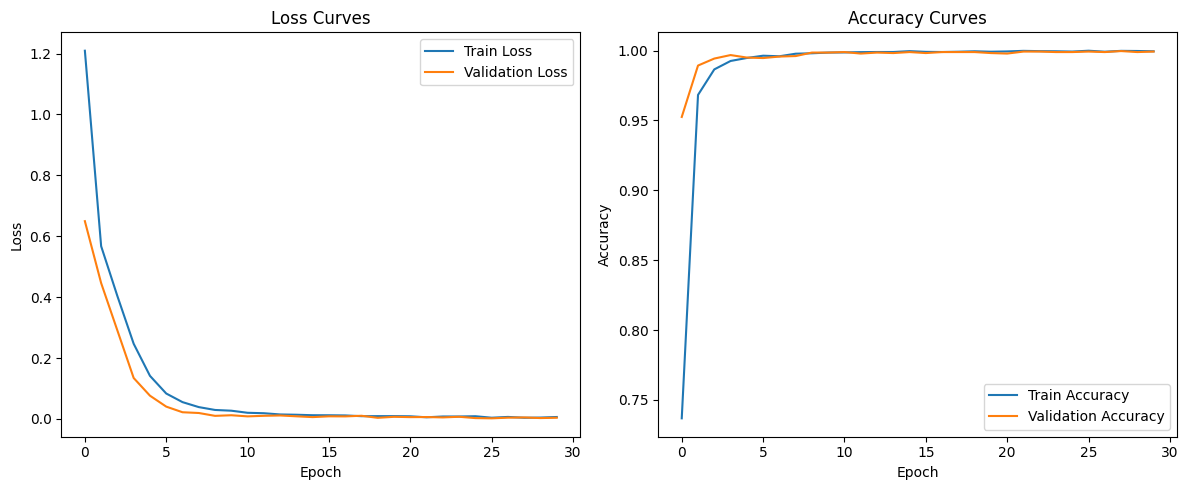


Final Ensemble Weights:
VGG16: 0.3362
VGG19: 0.3083
MobileNet: 0.1727
MobileNetV2: 0.1828


Testing: 100%|██████████| 70/70 [00:08<00:00,  8.14it/s]


Test Loss: 0.0008, Test Acc: 1.0000
Predictions saved to predictions.csv


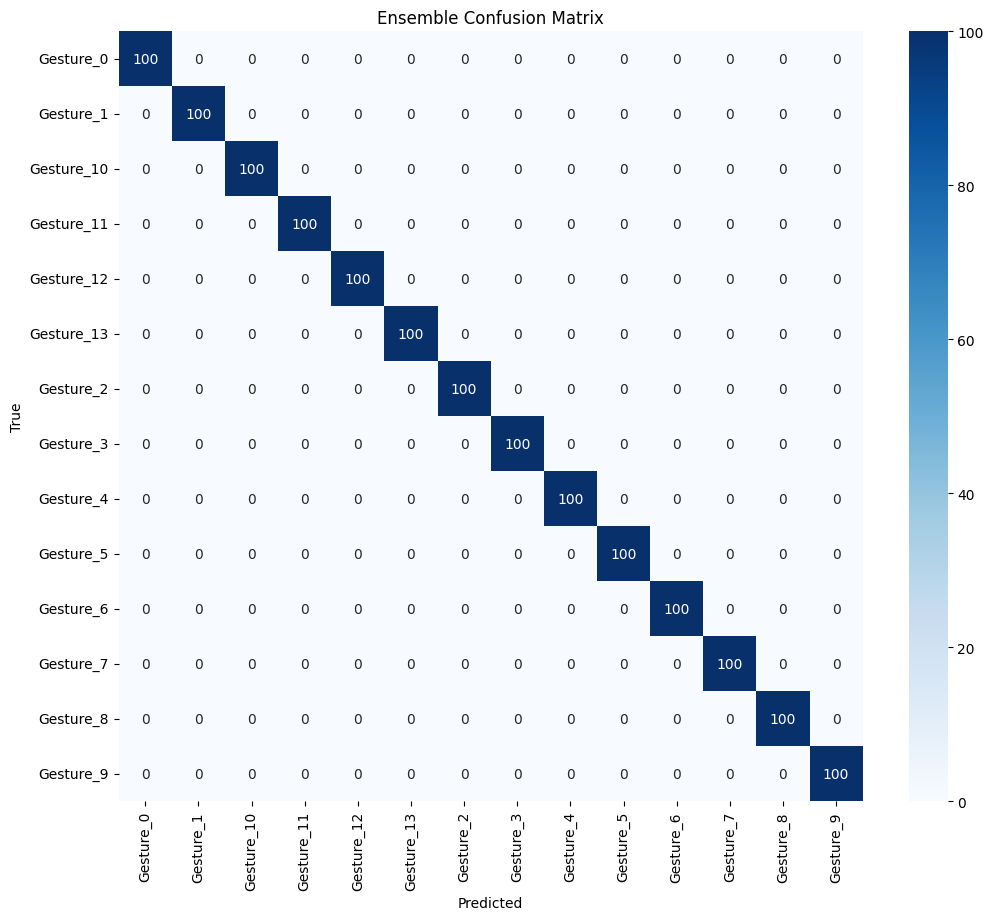


Ensemble Classification Report:
              precision    recall  f1-score   support

   Gesture_0       1.00      1.00      1.00       100
   Gesture_1       1.00      1.00      1.00       100
  Gesture_10       1.00      1.00      1.00       100
  Gesture_11       1.00      1.00      1.00       100
  Gesture_12       1.00      1.00      1.00       100
  Gesture_13       1.00      1.00      1.00       100
   Gesture_2       1.00      1.00      1.00       100
   Gesture_3       1.00      1.00      1.00       100
   Gesture_4       1.00      1.00      1.00       100
   Gesture_5       1.00      1.00      1.00       100
   Gesture_6       1.00      1.00      1.00       100
   Gesture_7       1.00      1.00      1.00       100
   Gesture_8       1.00      1.00      1.00       100
   Gesture_9       1.00      1.00      1.00       100

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00    

In [19]:
def main():
    """
    Main execution function that implements the combined Dirichlet ensemble approach
    """
    # Create the ensemble model
    model = DirichletEnsembleModel(NUM_CLASSES)
    model = model.to(device)
    
    # Check if pre-trained model exists
    model_path = "ensemble_best.pth"
    if os.path.exists(model_path):
        print("Loading pre-trained ensemble model...")
        model.load_state_dict(torch.load(model_path))
    else:
        print("Training ensemble model from scratch...")
        # Set up training
        criterion = nn.CrossEntropyLoss()
        
        # Create parameter groups with different learning rates
        # Lower learning rate for pre-trained layers
        base_model_params = []
        for name, param in model.named_parameters():
            if not name.startswith('ensemble_weights'):
                base_model_params.append(param)
        
        optimizer = optim.Adam([
            {'params': base_model_params, 'lr': LEARNING_RATE * 0.1},  # Lower learning rate for base models
            {'params': model.ensemble_weights, 'lr': LEARNING_RATE}    # Higher learning rate for ensemble weights
        ])
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        
        # Train model
        model, history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                                     scheduler, NUM_EPOCHS)
        
        # Plot learning curves
        plot_learning_curves(history)
    
    # Display final ensemble weights
    weights = torch.softmax(model.ensemble_weights, dim=0).detach().cpu().numpy()
    print("\nFinal Ensemble Weights:")
    print(f"VGG16: {weights[0]:.4f}")
    print(f"VGG19: {weights[1]:.4f}")
    print(f"MobileNet: {weights[2]:.4f}")
    print(f"MobileNetV2: {weights[3]:.4f}")
    
    # Evaluate on test set
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, preds, labels = evaluate_model(model, test_loader, criterion)
    save_predictions_to_file(preds, labels, train_dataset.classes)
    
    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, train_dataset.classes, "Ensemble Confusion Matrix")
    
    # Print classification report
    print("\nEnsemble Classification Report:")
    print(classification_report(labels, preds, target_names=train_dataset.classes))
    
    return model

if __name__ == "__main__":
    main()